In [130]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.misc import imread
from PIL import Image

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras import backend as K

In [131]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
DATA_PATH = '/a/data/fisheries_monitoring/data/'

In [132]:
aug_folders = glob.glob(DATA_PATH + 'localizers/*')
aug_folders = aug_folders[1:]
for i, folder in enumerate(aug_folders):
    print "index:", i, '\t', "folder name:", folder

index: 0 	folder name: /a/data/fisheries_monitoring/data/localizers/invert
index: 1 	folder name: /a/data/fisheries_monitoring/data/localizers/vflip
index: 2 	folder name: /a/data/fisheries_monitoring/data/localizers/add
index: 3 	folder name: /a/data/fisheries_monitoring/data/localizers/emboss
index: 4 	folder name: /a/data/fisheries_monitoring/data/localizers/gaussianNoise
index: 5 	folder name: /a/data/fisheries_monitoring/data/localizers/blur
index: 6 	folder name: /a/data/fisheries_monitoring/data/localizers/original
index: 7 	folder name: /a/data/fisheries_monitoring/data/localizers/dropout
index: 8 	folder name: /a/data/fisheries_monitoring/data/localizers/rotate


In [133]:
def load_all_labels(aug_folders):
    all_labels = pd.DataFrame(columns = ["img", "x","y","w","h"])
    for folder in aug_folders:
        folder_name = os.path.basename(folder)
        print "Loading data augmentation folder:", folder_name
        labels = pd.read_csv(folder + '/superboxes.csv', names = ["img", "x","y","w","h"])
        labels = labels.sort_values(by = "img")
        labels["img"] = folder_name + '/' + labels["img"]
        print "Number of examples:", len(labels)
        print
        all_labels = all_labels.append(labels)
    print "total number of examples: ", len(all_labels)
    return all_labels


def train_val_test_split(all_labels, val_size, test_size):
    all_labels = shuffle(all_labels, random_state = 8574)
    test_labels = all_labels[0:test_size]
    val_labels = all_labels[test_size:test_size + val_size]
    train_labels = all_labels[test_size + val_size:]
    return train_labels, val_labels, test_labels


def data_generator(batch_size, labels, INPUT_WIDTH, INPUT_HEIGHT):
    while True:
        img_batch = np.zeros((batch_size, INPUT_WIDTH, INPUT_HEIGHT, 3))
        box_batch = np.zeros((batch_size, 4))
        for i in xrange(batch_size):
            n = np.random.choice(len(labels))
            file_name = labels.iloc[n]["img"]
            path = DATA_PATH + 'localizers/' + file_name
            img = image.load_img(path)
            width, height = img.size
            img = img.resize((INPUT_WIDTH, INPUT_HEIGHT))
            img = image.img_to_array(img)
            img /= 255
            img_batch[i] = img
            
            old_x, old_y, old_w, old_h = labels.iloc[n][["x","y","w","h"]]
            new_x = old_x / width
            new_y = old_y / height
            new_w = old_w / width
            new_h = old_h / height
            box = np.array([new_x, new_y, new_w, new_h])
            box_batch[i] = box
        
        yield (img_batch, box_batch)


def load_data(labels, INPUT_WIDTH, INPUT_HEIGHT):
    X = []
    y = []
    idx = []
    X_raw = []
    y_raw = [] 
    shape_raw = []
    for i in xrange(len(labels)):
        file_name = labels.iloc[i]["img"]
        path = DATA_PATH + 'localizers/' + file_name
        img_raw = image.load_img(path)
        width, height = img_raw.size
        img = img_raw.resize((INPUT_WIDTH,INPUT_HEIGHT))
        
        img_raw = image.img_to_array(img_raw)
        img_raw /= 255
        img = image.img_to_array(img)
        img /= 255
        
        old_x, old_y, old_w, old_h = labels.iloc[i][["x","y","w","h"]]
        new_x = old_x / width
        new_y = old_y / height
        new_w = old_w / width
        new_h = old_h / height

        X.append(img)
        y.append(np.array([new_x, new_y, new_w, new_h]))
        idx.append(file_name)
        X_raw.append(img_raw)
        shape_raw.append(np.array([width, height]))
        
        if (i+1) in [k*len(labels)/5 for k in xrange(1,6)]:
                print "Loading...{}% done!".format((i+2)*100/len(labels))
        
    return np.array(X), np.array(y), np.array(idx), np.array(X_raw), np.array(shape_raw)

In [134]:
all_labels = load_all_labels(aug_folders)

Loading data augmentation folder: invert
Number of examples: 6618

Loading data augmentation folder: vflip
Number of examples: 13236

Loading data augmentation folder: add
Number of examples: 6618

Loading data augmentation folder: emboss
Number of examples: 3309

Loading data augmentation folder: gaussianNoise
Number of examples: 9927

Loading data augmentation folder: blur
Number of examples: 6618

Loading data augmentation folder: original
Number of examples: 3774

Loading data augmentation folder: dropout
Number of examples: 6618

Loading data augmentation folder: rotate
Number of examples: 23162

total number of examples:  79880


In [135]:
selected_aug = {"ALB" : ["original", "vflip", "rotate"],
                "BET" : ["original", "vflip", "rotate"],
                "DOL" : ["original", "vflip", "rotate"],
                "LAG" : ["original", "vflip", "rotate"],
                "OTHER" : ["original", "vflip", "rotate"],
                "SHARK" : ["original", "vflip", "rotate"],
                "YFT" : ["original", "vflip", "rotate"]}
selected_labels = pd.DataFrame(columns = ["img", "x","y","w","h"])
for key, values in selected_aug.iteritems():
    for value in values:
        labels_tmp = all_labels[all_labels["img"].str.startswith(value + '/' + key)]
        selected_labels = selected_labels.append(labels_tmp)

In [136]:
original_labels = all_labels[all_labels["img"].str.contains("original")]
original_labels = original_labels[~original_labels["img"].str.contains("NoF")]

In [137]:
train_labels, val_labels, test_labels = train_val_test_split(original_labels, int(0.2*len(original_labels)), 0)

In [138]:
aug_train_labels = selected_labels.copy()
for label in val_labels["img"]:
    label = label[9:-4]
    ind = selected_labels[selected_labels["img"].str.contains(label)].index
    aug_train_labels = aug_train_labels.drop(ind)

In [139]:
print "original data size: ", len(original_labels)
print "all data size: ", len(all_labels)
print "selected data size: ", len(selected_labels)
print "train data size:", len(train_labels)
print "validation data size:", len(val_labels)
print "test data size:", len(test_labels)
print "augmented train data size:", len(aug_train_labels)
print "number of times augmented:", float(len(aug_train_labels)) / len(train_labels)

original data size:  3309
all data size:  79880
selected data size:  39707
train data size: 2648
validation data size: 661
test data size: 0
augmented train data size: 27083
number of times augmented: 10.2277190332


## Define model

In [127]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(INPUT_WIDTH, INPUT_HEIGHT,3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation = 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error')

## Start training

In [128]:
batch_size = 30
steps_per_epoch = len(train_labels) / batch_size
nb_epoch = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

history = model.fit_generator(generator = data_generator(batch_size, aug_train_labels, INPUT_WIDTH, INPUT_HEIGHT), 
                              steps_per_epoch = steps_per_epoch,
                              epochs=nb_epoch,
                              verbose=1,
                              callbacks = callbacks,
                              validation_data = data_generator(batch_size, val_labels, INPUT_WIDTH, INPUT_HEIGHT),
                              validation_steps = 5)
model.save(DATA_PATH + 'models/localizers/localizer3.h5')

Epoch 1/30
13/88 [===>..........................] - ETA: 38s - loss: 0.1559 

KeyboardInterrupt: 

## Visualize prediction

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

def visualize_prediction(img, index = None, true_box = None, pred_box = None, ax = None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.imshow(img)
    if index is not None:
        ax.set_title(index)
    height = img.shape[0]
    width = img.shape[1]
    
    if true_box is not None:
        x, y, w, h = true_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='\\',
            fill=False,      # remove background
            color = 'r',
            linewidth = 2.5
                )
            )
    if pred_box is not None:
        x, y, w, h = pred_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='-',
            fill=False,      # remove background
            color = 'k',
            linewidth = 2.5
                )
            )

def make_plot(data, nrow = 2, ncol = 2, index = None, true_box = None, pred_box = None, figsize = (15,8)):
    # Create grid
    _, ax = plt.subplots(nrow, ncol, figsize=figsize)
    
    idx = None
    tbox = None
    pbox = None
    # Generate indices of images to show
    for axi in np.ravel(ax):
        n = np.random.choice(len(data))
        img = data[n]
        if index is not None:
            idx = index[n]
        if true_box is not None:
            tbox = true_box[n]
        if pred_box is not None:
            pbox = pred_box[n]
        
        # Visualize it along with the box
        visualize_prediction(img, index = idx, true_box = tbox, pred_box = pbox, ax = axi)

print "Loading validation data:"
X_test, y_test, id_test, X_test_raw, shape_raw = load_data(val_labels, INPUT_WIDTH, INPUT_HEIGHT)

print "Predicting:"
localizer = load_model(DATA_PATH + 'models/localizers/localizer3.h5')
y_pred = localizer.predict(X_test.astype('float32'), verbose=1)
print "test loss:", mean_squared_error(y_test, y_pred)

Loading validation data:
Loading...20% done!
Loading...40% done!
Loading...60% done!
Loading...80% done!
Loading...100% done!
Predicting:
874/874 [==============================] - 10s     

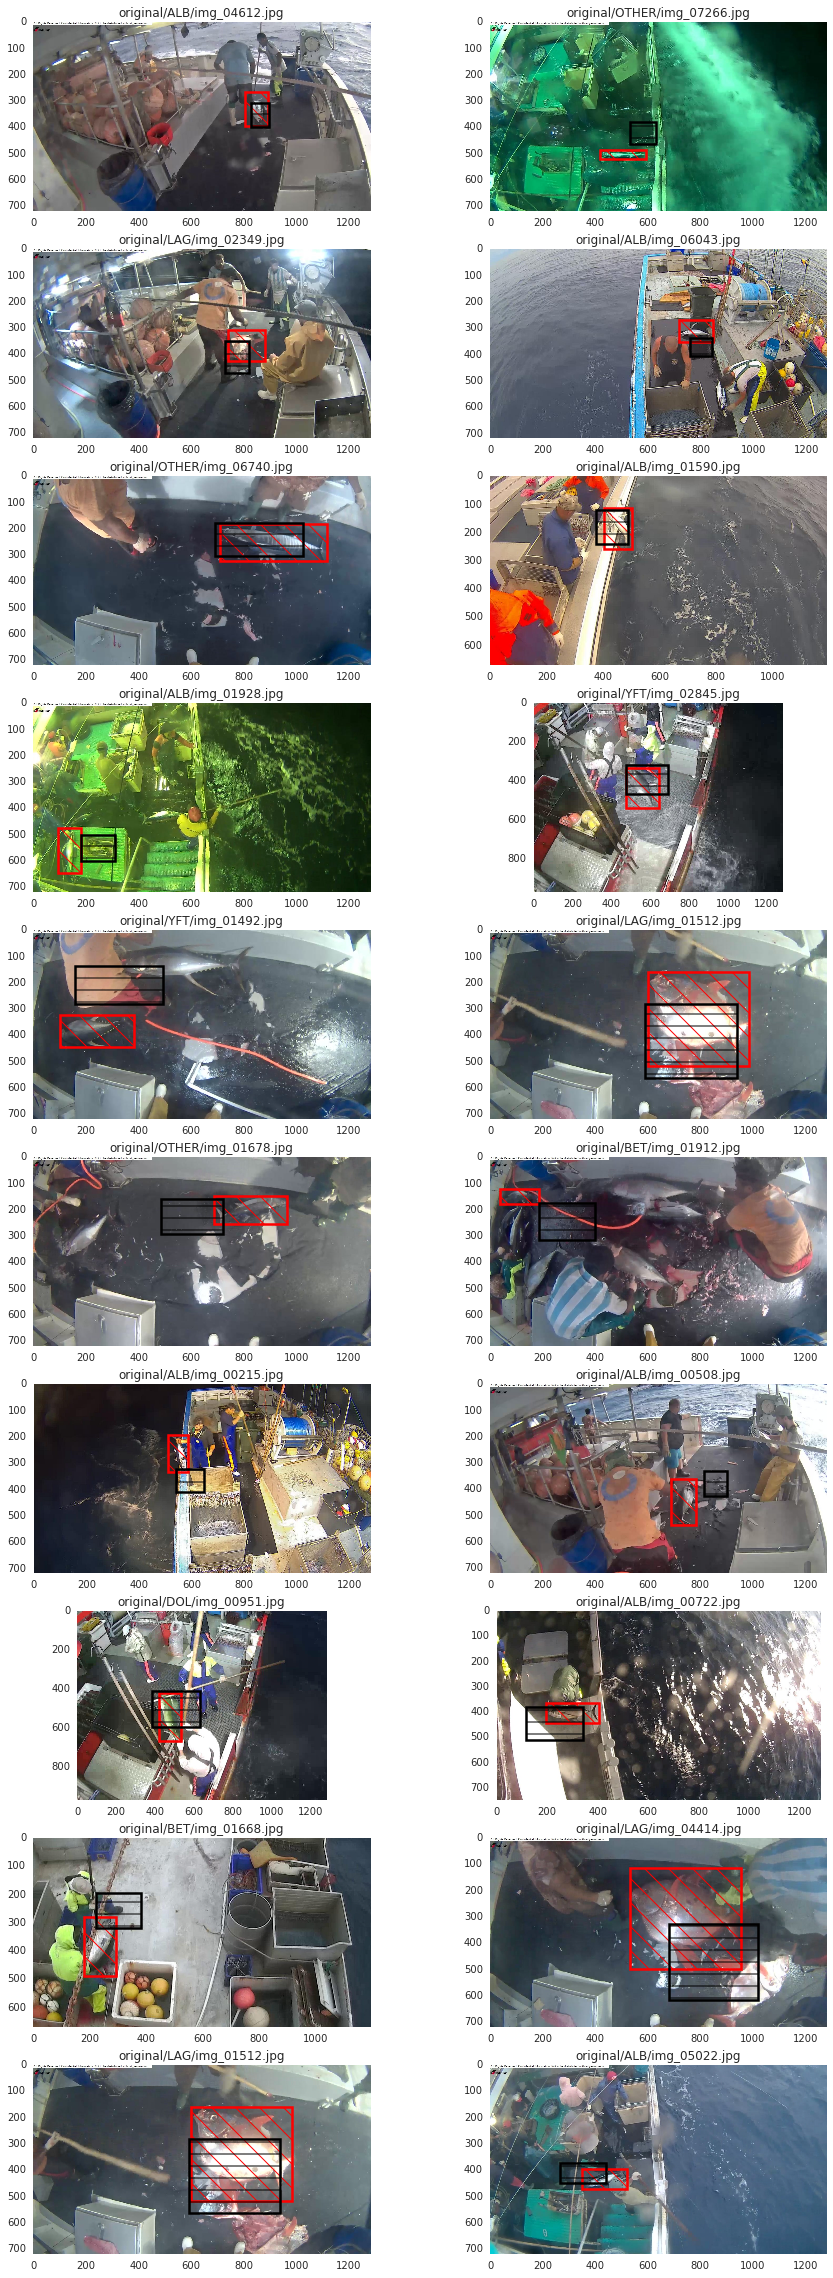

In [16]:
# Make plot
# The true boxes have the color red and patch pattern of '\\'
# The predicted boxes have the color black and patch pattern of '-'
make_plot(data = X_test_raw,
          nrow = 10, 
          ncol = 2, 
          index = id_test, 
          true_box = y_test, 
          pred_box = y_pred, 
          figsize = (15, 40))